<a href="https://colab.research.google.com/github/christopherfoot/Electrodynamic_apparatus/blob/main/Copy_of_Untitled9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

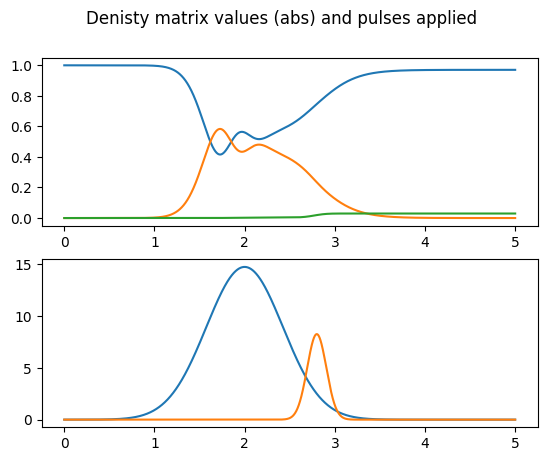

In [ ]:
from math import pi, sqrt, log
import numpy as np
from matplotlib import pyplot as plt

#Two-level Optical Bloch Equation (aka Maxwell Bloch) solver

T=5
Nt=int(5e3)
t = np.linspace(0, T, Nt+1)
dt=t[1]-t[0]
t2N= np.linspace(0, T, 2*Nt+1)
t2N= np.append(t2N,[T+dt/2,T+dt])

# parameters: detuning, (decay rates)
Delta = .0001
Gamma_ee = 5.
Rion_one =  .05
Rion_two = .00005

# Define two pulses at t0 and t1 seconds, with areas (in units of pi) and FWHMs
t0=2
area0= 5.*np.pi
fwhm_t0=1.

t1=2.8
area1=.7*np.pi
fwhm_t1=.25

# make Gaussian pulses with given FWHM and area

def gaussian_pulse(ti,t0,fwhm_t):
    return np.exp(-(4/fwhm_t**2)*((ti-t0)**2)*log(2))

amplitude0=area0/(np.sum(gaussian_pulse(t,t0,fwhm_t0))*dt)
def Omega(ti):
    return amplitude0*(gaussian_pulse(ti,t0,fwhm_t0) )
#    return amplitude*(gaussian_pulse(ti,t0,fwhm_t)+gaussian_pulse(ti,t1,fwhm_t))

amplitude1=area1/(np.sum(gaussian_pulse(t,t1,fwhm_t1))*dt)
def Pulse2(ti):
    return amplitude1*(gaussian_pulse(ti,t1,fwhm_t1) )

####For speed you might want to pre-calculate Rabi frequency pulses, but you must pre-calculate at twice the sampling such that RK4 will work
#Then create some function mapping ti to the correct index in Omega.

omega2t=Omega(t2N)
def OmegaA(ti):
    return omega2t[int(2*ti/dt)]

pulse2t=Pulse2(t2N)
def pulseA(ti):
    return pulse2t[int(2*ti/dt)]

#MB Equations for density matrix elements

def d_rho(ti,rho):
    drho=np.empty([2,2],dtype='complex')
    #omega=Omega(ti)
    omega=OmegaA(ti)
    pulse_I=pulseA(ti)
    Gamma = Gamma_ee +Rion_one*pulse_I +Rion_two*omega*omega
#    drho[0,0]=0.5j*omega*(rho[1,0]-rho[0,1]) + Gamma_e*rho[1,1]
#    drho[1,1]=0.5j*omega*(rho[0,1]-rho[1,0])- (omega*omega*Gamma+Gamma_e +Gamma_I*pulse_I)*rho[1,1]
#    drho[0,1]=0.5j*omega*(rho[1,1]-rho[0,0])-(1j*Delta+Gamma/2)*rho[0,1]
#    drho[1,0]=0.5j*omega*(rho[0,0]-rho[1,1])-(-1j*Delta+Gamma/2)*rho[1,0]
    drho[0,0]=0.5j*omega*(rho[1,0]-rho[0,1]) + Gamma_ee*rho[1,1]
    drho[1,1]=0.5j*omega*(rho[0,1]-rho[1,0])- Gamma*rho[1,1]
    drho[0,1]=0.5j*omega*(rho[1,1]-rho[0,0]) -(1j*Delta+Gamma/2)*rho[0,1]
    drho[1,0]=0.5j*omega*(rho[0,0]-rho[1,1]) -(-1j*Delta+Gamma/2)*rho[1,0]
    return drho

#RK4 Solver

def step(ti,rho):
    k1=d_rho(ti,rho)
    k2=d_rho(ti+(dt/2),rho+(dt/2)*k1)
    k3=d_rho(ti+(dt/2),rho+(dt/2)*k2)
    k4=d_rho(ti+dt,rho+dt*k3)
    return rho+(dt/6)*(k1+2*k2+2*k3+k4)

#returns a N x 2 x 2 matrix where the 2x2 is the denisty matrix

def solver(t,rho0):
    rho=rho0
    rho_out_t=np.empty([len(t),2,2],dtype='complex')

    for idx, ti in enumerate(t):
        rho_out_t[idx]=rho
        rho=step(ti,rho)
    return rho_out_t

#start in the ground state
rho0=np.zeros([2,2],dtype='complex')
rho0[0,0]=1

#run the solver

rho_out_t=solver(t,rho0)

fig, (ax1, ax2) = plt.subplots(2)
fig.suptitle("Denisty matrix values (abs) and pulses applied")
ax1.plot(t,np.abs(rho_out_t[:,0,0]))
ax1.plot(t,np.abs(rho_out_t[:,1,1]))
ax1.plot(t,1-np.abs(rho_out_t[:,0,0])-np.abs(rho_out_t[:,1,1]))
ax2.plot(t,Omega(t))
ax2.plot(t,Pulse2(t))
plt.show()